In [1]:
import vista
import os
from vista.utils import logging
import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
# import tensorflow_probability as tfp

# import mitdeeplearning as mdl
logging.setLevel(logging.ERROR)

2023-02-27 18:35:35,195::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it


In [2]:
### Agent Memory ###

class Memory:
    def __init__(self): 
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        self.actions.append(new_action)
        self.rewards.append(new_reward)

    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

In [3]:
### Access documentation for VISTA
### Run ?vista.<[name of module or function]>
?vista.Display 

Init signature:
vista.Display(
    world: vista.core.World.World,
    fps: Union[float, NoneType] = 30,
    display_config: Union[Dict, NoneType] = {},
)
Docstring:     
This is a visualizer of VISTA simulator. It renders an image that contains visualization
of all sensors from all agents and a top-down view that depicts road and all cars in the scene
within a predefined range based on the state of the simulator (:class:`World`).

Args:
    world (vista.core.World): World to be visualized.
    fps (int): Frame per second.
    display_config (Dict): Configuration for the display (visualization).

Raises:
    AssertionError: Grid spec is inconsistent with maximal number of sensors across agents.

Example usage::

    >>> display_config = {
        'road_buffer_size': 200,
        'birdseye_map_size': (30, 20), # size of bev map in vertical and horizontal directions
        'gs_bev_w': 2, # grid spec width for the birdseye view block
        'gs_agent_w': 4, # grid spec width for an agent

In [4]:
trace_root = 'trace'
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]
trace_path

['trace/20210726-154641_lexus_devens_center',
 'trace/20210726-155941_lexus_devens_center_reverse',
 'trace/20210726-184624_lexus_devens_center',
 'trace/20210726-184956_lexus_devens_center_reverse']

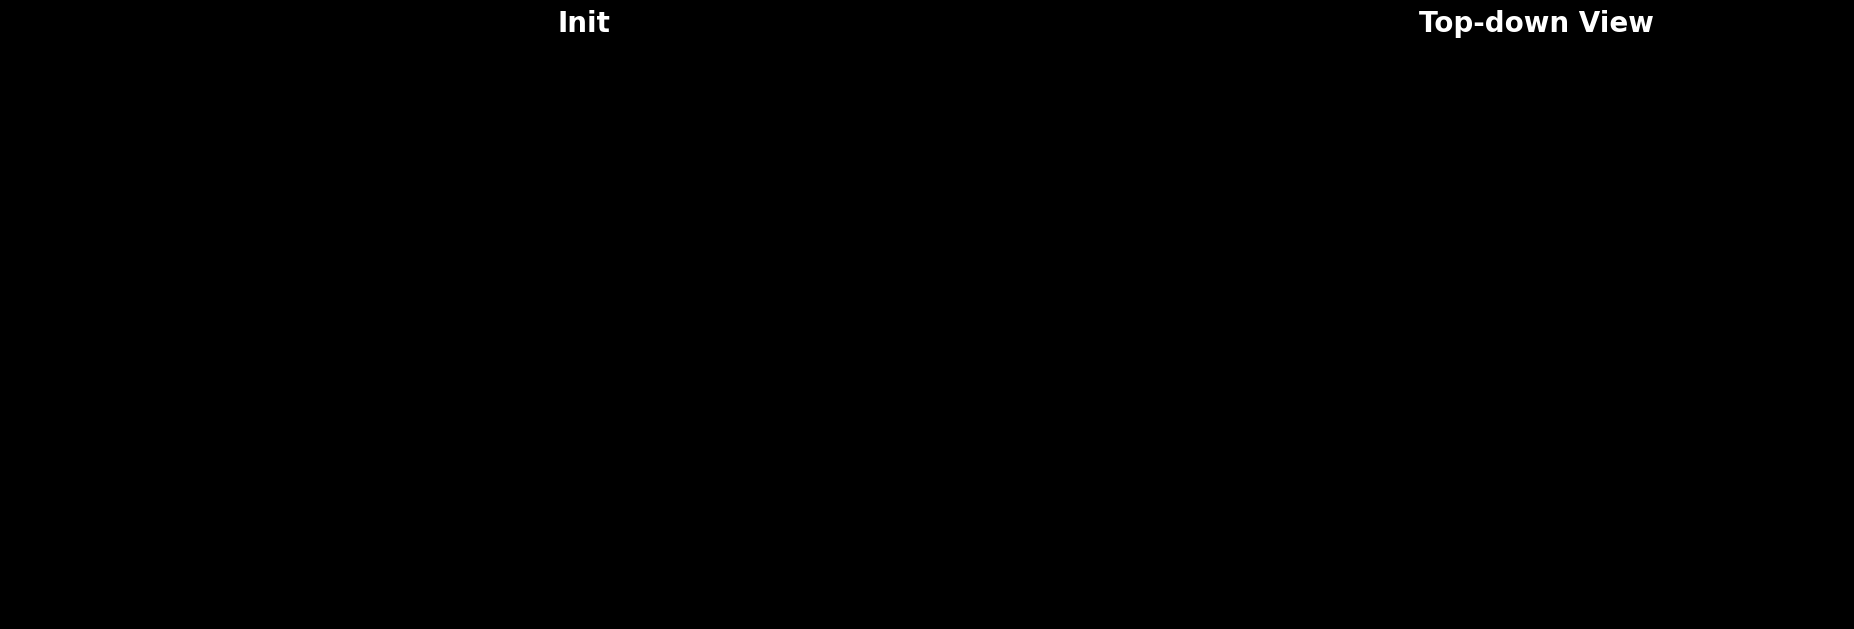

In [5]:
world = vista.World(trace_path, trace_config={'road_width': 4})

# Create a car in our virtual world. The car will be able to step and take different 
#   control actions. As the car moves, its sensors will simulate any changes it environment
car = world.spawn_agent(
    config={
        'length': 5.,
        'width': 2.,
        'wheel_base': 2.78,
        'steering_ratio': 14.7,
        'lookahead_road': True
    })

# Create a camera on the car for synthesizing the sensor data that we can use to train with! 
camera = car.spawn_camera(config={'size': (200, 320)})

# Define a rendering display so we can visualize the simulated car camera stream and also 
#   get see its physical location with respect to the road in its environment. 
display = vista.Display(world, display_config={"gui_scale": 2, "vis_full_frame": False})

# Define a simple helper function that allows us to reset VISTA and the rendering display
def vista_reset():
    world.reset()
    display.reset()
vista_reset()

In [6]:
# First we define a step function, to allow our virtual agent to step 
# with a given control command through the environment 
# agent can act with a desired curvature (turning radius, like steering angle)
# and desired speed. if either is not provided then this step function will 
# use whatever the human executed at that time in the real data.

def vista_step(curvature=None, speed=None):
    # Arguments:
    #   curvature: curvature to step with
    #   speed: speed to step with
    if curvature is None: 
        curvature = car.trace.f_curvature(car.timestamp)
    if speed is None: 
        speed = car.trace.f_speed(car.timestamp)
    
    car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)
    car.step_sensors()

In [7]:
import shutil, os, subprocess, cv2

# Create a simple helper class that will assist us in storing videos of the render
class VideoStream():
    def __init__(self):
        self.tmp = "./tmp"
        if os.path.exists(self.tmp) and os.path.isdir(self.tmp):
            shutil.rmtree(self.tmp)
        os.mkdir(self.tmp)
    def write(self, image, index):
        cv2.imwrite(os.path.join(self.tmp, f"{index:04}.png"), image)
    def save(self, fname):
        cmd = f"/opt/homebrew/bin/ffmpeg -i {self.tmp}/%04d.png -crf 0 -y {fname}"
        subprocess.call(cmd, shell=True)
        

In [8]:
## Render and inspect a human trace ##

# vista_reset()
# stream = VideoStream()

# for i in tqdm(range(100)):
#     vista_step()
    
#     # Render and save the display
#     vis_img = display.render()
#     stream.write(vis_img[:, :, ::-1], index=i)
#     if car.done: 
#         break

# print("Saving trajectory of human following...")
# stream.save("human_follow.mp4");
# mdl.lab3.play_video("human_follow.mp4")

In [9]:
## Define terminal states and crashing conditions ##

def check_out_of_lane(car):
    distance_from_center = np.abs(car.relative_state.x)
    road_width = car.trace.road_width 
    half_road_width = road_width / 2
    return distance_from_center > half_road_width

def check_exceed_max_rot(car):
    maximal_rotation = np.pi / 10.
    current_rotation = np.abs(car.relative_state.yaw)
    return current_rotation > maximal_rotation

def check_crash(car): 
    return check_out_of_lane(car) or check_exceed_max_rot(car) or car.done

In [10]:
## Behavior with random control policy ##

# i = 0
# num_crashes = 5
# stream = VideoStream()

# for _ in range(num_crashes):
#     vista_reset()
    
#     while not check_crash(car):

#         # Sample a random curvature (between +/- 1/3), keep speed constant
#         curvature = np.random.uniform(-1/3, 1/3)

#         # Step the simulated car with the same action
#         vista_step(curvature=curvature)

#         # Render and save the display
#         vis_img = display.render()
#         stream.write(vis_img[:, :, ::-1], index=i)
#         i += 1
    
#     print(f"Car crashed on step {i}")
#     for _ in range(5):
#         stream.write(vis_img[:, :, ::-1], index=i)
#         i += 1

# print("Saving trajectory with random policy...")
# stream.save("random_policy.mp4")

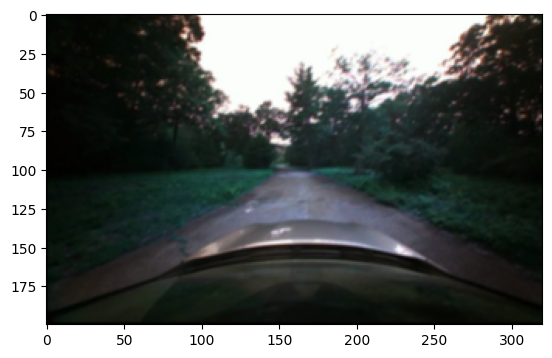

In [11]:
%matplotlib inline
import cv2

# Directly access the raw sensor observations of the simulated car
vista_reset()
full_obs = car.observations[camera.name]

plt.imshow(full_obs)
plt.show()

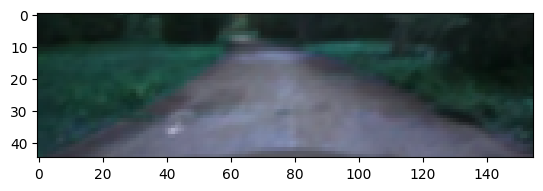

In [12]:
## ROIs ##

# Crop a smaller region of interest (ROI). This is necessary because: 
#   1. The full observation will have distortions on the edge as the car deviates from the human
#   2. A smaller image of the environment will be easier for our model to learn from
region_of_interest = camera.camera_param.get_roi()
i1, j1, i2, j2 = region_of_interest
cropped_obs = full_obs[i1:i2, j1:j2]
plt.imshow(cropped_obs)
plt.show()

In [13]:
cropped_obs.shape

(45, 155, 3)

In [14]:
## Data preprocessing functions ##

def preprocess(full_obs):
    # Extract ROI
    i1, j1, i2, j2 = camera.camera_param.get_roi()
    obs = full_obs[i1:i2, j1:j2]
    
    # Rescale to [0, 1]
    obs = obs / 255.
    return obs

def grab_and_preprocess_obs(car):
    full_obs = car.observations[camera.name]
    obs = preprocess(full_obs)
    return obs

In [36]:
### Define the self-driving agent ###
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import ReLU
import torch.nn.functional as F  # for the activation function

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 48, 5)
        self.conv3 = nn.Conv2d(48, 64, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 35 * 145, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x    

# driving_model = create_driving_model()
model = NeuralNetwork()
model

Using mps device


NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=324800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [32]:
## TESTING BLOCK

model = NeuralNetwork()
model

observation = grab_and_preprocess_obs(car)
single_image_input = len(observation.shape) == 3  
observation =  np.float32(observation)
observation = torch.from_numpy(observation)

# observation = torch.unsqueeze(observation, dim=0)
# observation = observation.permute(0,3,1,2)

# distribution = model(observation)
# distribution, distribution[0][0], distribution[0][1]
# torch.split(distribution, 1, dim=1)

curvature_dist = run_driving_model(observation)
curvature_dist.mean

tensor([[-0.0064]], grad_fn=<MulBackward0>)

In [17]:
## The self-driving learning algorithm ##

# hyperparameters
max_curvature = 1/8. 
max_std = 0.1 

def run_driving_model(image):
    # Arguments:
    #   image: an input image
    # Returns:
    #   pred_dist: predicted distribution of control actions 
    single_image_input = len(image.shape) == 3  # missing 4th batch dimension
    if single_image_input:
        image = torch.unsqueeze(image, dim=0)

    image = image.permute(0,3,1,2)
    distribution = driving_model(image) 

    mu, logsigma = torch.split(distribution, 1, dim=1)
    mu = max_curvature * torch.tanh(mu) # conversion
    sigma = max_std * torch.sigmoid(logsigma) + 0.005 # conversion
    
    pred_dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)

    return pred_dist


def compute_driving_loss(dist, actions, rewards):
    # Arguments:
    #   logits: network's predictions for actions to take
    #   actions: the actions the agent took in an episode
    #   rewards: the rewards the agent received in an episode
    # Returns:
    #   loss
    with torch.enable_grad():
        # print(f"type: {type(actions)}")
        neg_logprob = -1 * dist.log_prob(actions)
        neg_logprob = neg_logprob.detach().numpy() 
        total_loss = torch.tensor(neg_logprob * rewards, requires_grad=True)
        loss = torch.mean(total_loss) 
        return loss

In [18]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
      
    return normalize(discounted_rewards)

In [22]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, running_loss, custom_fwd_fn=None):
    # with tf.GradientTape() as tape:
    with torch.enable_grad():
        # Forward propagate through the agent network
        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else: 
            prediction = model(observations)

        loss = loss_function(prediction, actions, discounted_rewards) 
        loss.backward()
        running_loss += loss.item()
        print(f"loss: {running_loss}")
    # grads = torch.autograd.grad(loss, model.trainable_variables, grad_outputs=torch.ones_like(loss)) 
    # grads, _ = torch.clip_grad_norm_(grads, 2)
    # optimizer.apply_gradients(zip(grads, model.trainable_variables))
    optimizer.step()

## Train self-driving agent

In [23]:
## Training parameters and initialization ##
## Re-run this cell to restart training from scratch ##

# instantiate driving agent
vista_reset()
driving_model = NeuralNetwork()

learning_rate = 5e-4
optimizer = torch.optim.Adam(driving_model.parameters(), lr = learning_rate)

# NOTE: the variable driving_model will be used in run_driving_model execution

memory = Memory()

In [24]:
## Driving training! Main training block. ##
## Note: stopping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as 
#        well (to re-initialize the model and optimizer)

max_batch_size = 300
max_reward = float('-inf') # keep track of the maximum reward acheived during training
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
running_loss = 0.0
for i_episode in range(500):
    print(f"Episode: {i_episode}")
    # plotter.plot(smoothed_reward.get())
    # Restart the environment
    vista_reset()
    memory.clear()
    observation = grab_and_preprocess_obs(car) # torch.from_numpy(grab_and_preprocess_obs(car)).to(torch.float32).to(device).permute(2,0,1)
    # observation = torch.from_numpy(observation)
    # observation = torch.unsqueeze(observation, dim=0)
    while True:
        observation =  np.float32(observation)
        observation = torch.from_numpy(observation)
        curvature_dist = run_driving_model(observation)
        curvature_action = curvature_dist.sample()[0,0]
        vista_step(curvature_action)
        observation = grab_and_preprocess_obs(car)
        reward = 1.0 if not check_crash(car) else 0.0
        
        # add to memory
        memory.add_to_memory(observation, curvature_action, reward)
        
        # is the episode over? did you crash or do so well that you're done?
        if reward == 0.0:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            # smoothed_reward.append(total_reward)
            
            # execute training step - remember we don't know anything about how the 
            #   agent is doing until it has crashed! if the training step is too large 
            #   we need to sample a mini-batch for this step.
            batch_size = min(len(memory), max_batch_size)
            i = np.random.choice(len(memory), batch_size, replace=False)
            observation_batch = torch.from_numpy(np.float32(np.array(memory.observations)[i]))
            train_step(driving_model, compute_driving_loss, optimizer, 
                               observations=observation_batch,
                               actions=torch.from_numpy(np.array(memory.actions)[i]),
                               discounted_rewards = discount_rewards(memory.rewards)[i], 
                               running_loss=running_loss,
                               custom_fwd_fn=run_driving_model)            
            # reset the memory
            memory.clear()
            break
            

Episode: 0
loss: -0.16665028035640717
Episode: 1
loss: 0.019161682575941086
Episode: 2
loss: -0.04581986740231514
Episode: 3
loss: 0.036052361130714417
Episode: 4
loss: -0.06231766939163208
Episode: 5
loss: -0.019263867288827896
Episode: 6
loss: 0.11247465014457703
Episode: 7
loss: 0.08876515179872513
Episode: 8
loss: 0.11416681110858917
Episode: 9
loss: 0.007773424498736858
Episode: 10
loss: -0.359268456697464
Episode: 11
loss: -0.027668064460158348
Episode: 12
loss: 0.036192841827869415
Episode: 13
loss: 0.13973665237426758
Episode: 14
loss: -0.3464412987232208
Episode: 15
loss: 0.02245960384607315
Episode: 16


KeyboardInterrupt: 

In [35]:
## Evaluation block!##

i_step = 0
num_episodes = 5
num_reset = 5
stream = VideoStream()
for i_episode in range(num_episodes):
    
    # Restart the environment
    vista_reset()
    observation = grab_and_preprocess_obs(car)
    observation =  np.float32(observation)
    observation = torch.from_numpy(observation)
    
    print("rolling out in env")
    episode_step = 0
    while not check_crash(car) and episode_step < 100:
        # using our observation, choose an action and take it in the environment
        curvature_dist = run_driving_model(observation)
        curvature = curvature_dist.mean.detach().numpy()

        # Step the simulated car with the same action
        vista_step(curvature)
        observation = grab_and_preprocess_obs(car)
        observation =  np.float32(observation)
        observation = torch.from_numpy(observation)

        vis_img = display.render()
        stream.write(vis_img[:, :, ::-1], index=i_step)
        i_step += 1
        episode_step += 1
        
    for _ in range(num_reset):
        stream.write(np.zeros_like(vis_img), index=i_step)
        i_step += 1
        
print(f"Average reward: {(i_step - (num_reset*num_episodes)) / num_episodes}")

print("Saving trajectory with trained policy...")
stream.save("trained_policy.mp4")
# mdl.lab3.play_video("trained_policy.mp4")

rolling out in env


/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_14261/388717596.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)


rolling out in env


/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_14261/388717596.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)


rolling out in env


/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_14261/388717596.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)


rolling out in env


/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_14261/388717596.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)


rolling out in env


/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_14261/388717596.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)


Average reward: 35.6
Saving trajectory with trained policy...


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_4 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

NameError: name 'mdl' is not defined